<a href="https://colab.research.google.com/github/tomzaku/slide-catcha-deep-learning/blob/master/deep_learning_tutorial_with_huan_master.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from os import listdir, path
from os.path import isfile, join
import cv2 as cv
import sys
import numpy as np
import tensorflow as tf

# Dataset

In [ ]:
def is_image(filepath):
    if isfile(filepath):
        name, extension = path.splitext(filepath)
        return extension.endswith(".png")
    return False

def import_data(directory_path):
    # (filename, x, y)
    data = [(join(directory_path, f), int(f.split('_')[1]), int(f.split('_')[2].split('.')[0]))
            for f in listdir(directory_path)
            if is_image(join(directory_path, f))]

    validData = filter(
        lambda c: 0 <= c[1] <= 280 and 0 <= c[2] <= 150, data
    )
    
    return list(validData)


def format_data(data):
  local_inputs = []
  local_outputs = []
  for id, f in tqdm(enumerate(data)):
    img = cv.imread(f[0])
    if type(img) != type(None):
      local_inputs.append(img)
      local_outputs.append([[f[1], f[2]]])

  return np.array(local_inputs), np.array(local_outputs)


In [ ]:
data = import_data("/content/drive/MyDrive/Tri/coding/captcha/label-imgs")
x_train, y_train = format_data(data)
val_data = import_data("/content/drive/MyDrive/Tri/coding/captcha/val-imgs")
x_valid, y_valid = format_data(val_data)
x_train.shape, x_valid.shape

0it [00:00, ?it/s]

KeyboardInterrupt: ignored

# Build Model


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

# This one is underfit.
def build_model(input_shape):
    inputs = keras.Input(shape=input_shape)
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(2, activation="linear")(x)
    return keras.Model(inputs, outputs)

model = build_model(x_train.shape[1:])
model.compile(
    loss='mse', # bài toán này là regression nên dùng hàm loss là mse (mean square error)
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3)
)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 280, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 150, 280, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 75, 140, 32)       896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 140, 64)       18496     
_________________________________________________________________
separable_conv2d (SeparableC (None, 75, 140, 1024)     67136     
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2050  

# Train


In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=f'/content/drive/MyDrive/Tri/coding/captcha/model.h5', verbose=1,
                                 monitor='val_loss', mode='min',
                                 save_best_only=True, save_weights_only=False)

history = model.fit(
    x_train, 
    y_train,
    epochs=100, 
    validation_data=(x_valid, y_valid),
    callbacks=[checkpoint]
)

NameError: ignored

# Testing

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Tri/coding/captcha/model.h5')

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

NameError: ignored

(109.85288, 46.358795, array([[101,  87]]))

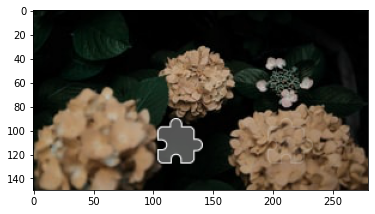

In [ ]:
i = 4
[[predict_x, predict_y]] = model.predict(np.array([x_valid[i]]))
plt.imshow(x_valid[i])
predict_x, predict_y, y_valid[i]

  0%|          | 0/30 [00:00<?, ?it/s]

(111.1186, 46.919815)

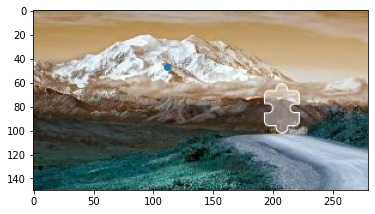

In [ ]:

def read_test_data(directory_path):
    data = [[join(directory_path, f)]
            for f in listdir(directory_path)
            if is_image(join(directory_path, f))]
    return np.array([cv.imread(f[0]) for f in tqdm(data[:30])])
test_data = read_test_data("/content/drive/MyDrive/Tri/coding/captcha/test-imgs")


i = 2
[[predict_x, predict_y]] = model.predict(np.array([test_data[i]]))
plt.imshow(test_data[i])
plt.scatter(predict_x,predict_y)

predict_x, predict_y